# Prediction with sklearn

By: Jacobo Fernandez-Vargas and Luca Citi

Based on the [scikit-learn documentation](http://scikit-learn.org/stable/tutorial/basic/tutorial.html)

## Loading the 'digits' dataset

Scikit-learn comes with a few standard datasets,
for instance the *Iris* and *digits* datasets for classification
and the *Boston house prices* dataset for regression.

In [30]:
from sklearn import datasets

digits = datasets.load_digits()

A dataset is a dictionary-like object that holds all the data and some metadata about the data.
The data is stored in the `.data` member,
which is usually a `n_samples` by `n_features` array.
In the case of supervised problem, one or more response variables are stored in the
`.target` member.

For instance, in the case of the digits dataset,
`digits.data` gives access to the features that can be used to classify the digits samples:

In [31]:
print(digits.data.shape)
print(digits.data)

(1797, 64)
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


and `digits.target` gives the ground truth for the digit dataset,
that is the number corresponding to each digit image that we are trying to learn:

In [32]:
print(digits.target.shape)
print(digits.target)

(1797,)
[0 1 2 ... 8 9 8]


## Learning and predicting
In the case of the digits dataset, the task is to predict, given an image,
which digit it represents.

We are given samples of each of the 10 possible classes (the digits 0 through 9).
These can be used to fit an estimator to predict the class an unseen example belongs to.

In scikit-learn, an estimator for classification is a Python object that implements the methods
`fit(X, y)` and `predict(T)`.

If you remember in the last lab we saw that the preprocessing classes had the methods
`fit(X, y)` and `transform(T)`. We will see the differences later.

An example of an estimator is the class `sklearn.svm.SVC` that implements
support vector classification.
The constructor of an estimator takes as arguments the parameters of the model,
but for the time being, we will consider the estimator as a black box:

In [33]:
from sklearn import svm

clf = svm.SVC(gamma=0.0001, C=100.)

We call our estimator instance `clf`, as it is a classifier.
**It now must be fitted to the model, that is, it must learn from the data**.
This is done by passing our training set to the `fit` method.

As a training set, let us use all the images of our dataset apart from the last one.
We select this training set with the `[:-1]` Python syntax,
which produces a new array that contains **all but the last entry** of `digits.data`:

In [34]:
clf.fit(digits.data[:-1], digits.target[:-1])

SVC(C=100.0, gamma=0.0001)

Now you can predict new values. In particular,
we can ask the classifier to recognise the digit of our last image in the digits dataset,
which we have not used to train the classifier:

In [35]:
clf.predict(digits.data[-1:])

array([8])

The corresponding image is the following.
As you can see, it is a challenging task: the images are of poor resolution.

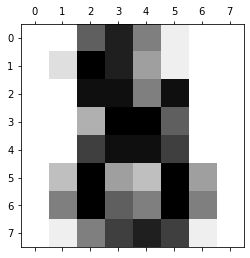

In [36]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

plt.matshow(digits.images[-1], cmap='binary')

## Grid-search

Almost all classifiers have parameters that need to be set.
The meaning and roles of these pararmeters differ largely between classifiers
and their appropiate selection can have huge impact on the results
(but some times they may have almost no effect).

This parameter fitting should happen inside a cross-validation process.

Scikit-learn provides `GridSeachCV` that, given data, fit of an estimator on each combination
of parameters on parameter grid and then chooses the parameters to maximize the
cross validation score.

To use this, we need to specify the classifier that we want to use
and the values of the parameters that we want to test (through a dictionary).

Interestingly, the  `GridSeachCV` constructor creates an object that can be used as a
predcictor, using its `fit`, `predict`, `score`, ... methods;
in other words it is a meta-predictor
(i.e. a preditor built from other predictors, an SVM in this case)
that can be used like any other predictors:

In [37]:
from sklearn.model_selection import GridSearchCV

clf = svm.SVC(gamma=0.01, C=10.)
Cs = np.logspace(-1, 3, 5)  # five logarithmically spaced values of C
Gs = np.logspace(-7, -0, 5)  # five logarithmically spaced values of gamma
clf = GridSearchCV(estimator=clf, param_grid=dict(C=Cs, gamma=Gs), n_jobs=-1)

clf.fit(digits.data, digits.target)
clf.score(digits.data, digits.target)

1.0

**IMPORTANT NOTE**

The way we trained and tested (fit, score) is WRONG!
You should not calculate the score with the same data used for training,
as we saw in the previous lectures and lab.

We did it this way for demonstration purposes of how the GridSeachCV class works.

The fact that we see a score of 1.0 (100%) should make us suspicious:
it's often a sign that we did something wrong (either that or the problem is trivial).

We can see how the different values of C and gamma affect the performance:

Best parameters:  {'C': 100.0, 'gamma': 0.00031622776601683794}


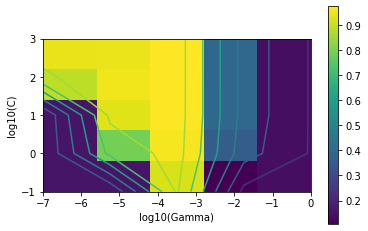

In [38]:
# Grid results for last fold
scores = clf.cv_results_['mean_test_score'].reshape(len(Cs), len(Gs))
extent = np.log10([Gs[0], Gs[-1], Cs[0], Cs[-1]])
im = plt.imshow(scores, extent=extent, origin='lower')
plt.colorbar(im)
plt.contour(np.log10(Gs), np.log10(Cs), scores)
plt.xlabel('log10(Gamma)')
plt.ylabel('log10(C)')
print('Best parameters: ', clf.best_params_)

## Automated cross validation

In the previous lab we saw the importance of using fold validation and
we saw a way of implementing it.

Fortunately, sklearn provides us with tools that take care of most of the heavy lifting:
`cross_val_score` and `cross_val_predict`.

The former returns only the score (the error function value, for example MSE),
while the latter returns all the predicted values.

In general, the score is enough to validate a model and compare different options.
However, having all the predicted values may be useful in some cases.

The following code may take some time as it is performing nested cross-validation.
This is because the `cross_val_score` function performs cross-validation on a
meta-predictor that internally performs another cross-validation loop.

The result is a nested cross-validation where `cross_val_score`
performs the outer loop for performance estimation and the `GridSeachCV`
object takes care of the inner one for parameter tuning.

In [39]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate

score = cross_val_score(clf, digits.data, digits.target, cv=5)
print(score)


[0.98055556 0.95555556 0.98050139 0.98885794 0.95821727]


As you can see the score from the fold validation varies fold to fold, and it is not 1.

## Pipelines

One of the most flexible tools provided by Scikit-learn are the pipelines.
These allow us to create sequential steps of preprocessing
(those that have `fit` and `transform` methods)
followed by a classifier
(that has `fit` and `predict` methods).

From the point of view of Scikit-learn, the pipeline itself is a classifier,
meaning that we can use directly the grid search and the cross validation classes.

(To speed up the processing, we are fixing the SVM's C parameter and tuning gamma only).

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
clf = svm.SVC(gamma=0.01, C=10.)
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
# Parameters of pipelines can be set using ‘__’
# between the name of the pipeline block and its parameter names:
class_c = np.logspace(-1, 3, 5)
class_gammas = np.logspace(-4, -3, 3)
param_grid = {
    'scaler__with_std': [True, False],
    'classifier__C': class_c,
    'classifier__gamma': class_gammas,
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
score = cross_val_score(search, digits.data, digits.target) 
print(score)

cv = KFold(shuffle=True)
scores = cross_validate(search, digits.data, digits.target, scoring=['accuracy'], cv=cv, return_estimator=True)

[0.97777778 0.95555556 0.98328691 0.98607242 0.9637883 ]


In this particular case, the inclusion of a scaler did not have any impact on the results
(because gray levels are somewhat already normalised and
possibly because we are not tuning C), but it may be extremely helpful in other cases.

5
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy'])


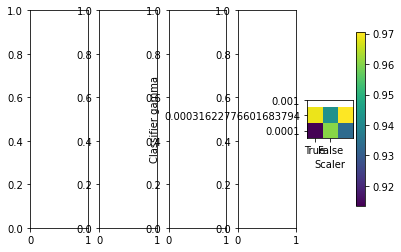

In [48]:
%matplotlib inline
from matplotlib import pyplot as plt

print(len(scores['estimator']))

fig, axes = plt.subplots(nrows=1, ncols=5)

for i in range(0, len(scores['estimator'])):
    ax = axes[i]
    est = scores['estimator'][i]
    
    thisScores = est.cv_results_['mean_test_score'].reshape(len(class_c), len(class_gammas))
    
    # TODO: finish doing this

features = np.zeros((len(param_grid['scaler__with_std']), len(param_grid['classifier__gamma'])))
for estimator in scores['estimator']:
    features += estimator.cv_results_['mean_test_score'].reshape(features.shape)
features /= len(scores['estimator'])

im = plt.imshow(features, origin='lower')
plt.colorbar(im)
plt.xticks(np.arange(len(param_grid['scaler__with_std'])), param_grid['scaler__with_std'])
plt.yticks(np.arange(len(param_grid['classifier__gamma'])), param_grid['classifier__gamma'])
plt.xlabel("Scaler")
plt.ylabel("Classifier gamma")
plt.show()

# Testing different classifiers

### Exercise 1

Try other classifiers to solve the problem and compare their results.
Suggestions for classifiers: Logistic Regression, Decision Trees.

You will need to look up the documentation to find which are the parameters to be fit
as well as the different classes available.

Once you do this, you will see how easy is to change the model and
test different approaches with this set up.

In [42]:


def classifier_tester(clf, clf_params, the_data):

    scl = StandardScaler()

    pline = Pipeline(
        [
            ("scaler",scl),
            ("classifier", clf)
        ]
    )





In [43]:


# Decision Tree

from sklearn import tree

kfold = KFold(shuffle=True, n_splits=5)

dtree = tree.DecisionTreeClassifier(max_depth=15, min_samples_leaf=1)


# Regression and unsupervised learning

In this lab we have seen how to use sklearn to solve a classification problem,
which is why we used support vector machines.

However, everything that we have seen here can be applied to both regression and
(to some extent) unsupervised learning.

Depending on the problem we will need to vary the model used for the prediction
but most of the concepts seen on this lab also apply to those cases.

### Exercise 2

Load the boston dataset form sklearn `datasets.load_boston` and
use what you have learned to solve a regression problem.

# Custom pipelines

This is a more advanced topic (and exercise) for those who would like to go beyond
scikit-learn's base functionalities
(it may require some familiarity with Python classes).

One of the advantages of the pipelines, is how easy it is to create new modules to
perform personalised steps and include them into the pipeline.

To do this, you only need to create a class that inherits both from `BaseEstimator`
and `TransformerMixin`.

Then the class must have the methods `__init__`, `fit`, `transform`,
and (optionally) `fit_transform`. It may have others methods if needed.

### Exercise 3

This is a more advanced exercise. Create a module that clips the data
(to remove outliers) based on the Inter Quartile Range (IQR) and a
multiplier ([Tukey's fences](https://en.wikipedia.org/wiki/Outlier#Tukey's_fences)).

The IQR is the distance between the first (Q1) and third (Q3) quartiles.

The module should clip those values that are below
Q1 - x\*IQR or above Q3 + x\*IQR
(remember that parameters, IQR in this case, must be fitted on training data only!).

You can use the following template:

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class ThresholdClipper(BaseEstimator, TransformerMixin):
    def __init__(self, qoffset=1.5):
        self.qoffset = qoffset

    def fit(self, X, y=None):
        ##TODO
        return self

    def transform(self, X, y=None):
        ##TODO
        return X

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X, y)

Now you can use this module inside your pipeline to remove outliers.